In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline
from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform
output_notebook()



Loading BokehJS ...

In [2]:
channels = ['"RFP"', '"YFP"', '"Brightfield"']

epoch_zero = 1518161340

fn_frames = {'180208_day0_0000_a3ic1/MMStack_Pos0.ome.tif': 3,
            '180208_day0_0000_a3ic1_1/180208_day0_12am_a3ic1_1_MMStack_Pos0.ome.tif': 21,
            '180208_day0_0853am_a3ic1/MMStack_Pos0.ome.tif':3,
            '180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif':66,
            '180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif':63,
            '180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif':12,
            '180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif':912,
            '180208_day1_1450am_a3ic1/MMStack_Pos0.ome.tif':726,
            '180208_day2_1115am_a3ic1/MMStack_Pos0.ome.tif':3,
            '180208_day2_1122am_a3ic1/MMStack_Pos0.ome.tif':12,
            '180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif':1555}

def img_metadata_dict(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 51123
    metadata_str = img.tag_v2[metadata_key][0]
    #metadata_terms = re.findall(r"(?<=\,\"|\{\"}).+?(?=\")", metadata_str)
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        key = re.search(r"(?<=\").*?(?=\")", split_x)[0]
        val = split_x.split(key)[-1][2:]
        metadata_keys.append(key)
        metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 51123
    
    metadata_str = img.tag_v2[metadata_key][0]

    #metadata_terms = re.findall(r"(?<=\,\"|\{\"}).+?(?=\")", metadata_str)
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        key = re.search(r"(?<=\").*?(?=\")", split_x)[0]
        val = split_x.split(key)[-1][2:]
        metadata_keys.append(key)
        metadata_vals.append(val)

    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][1:-1],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def get_time_vector_from_fn(fn):
    time_dict = {'"RFP"':[],'"YFP"':[],'"Brightfield"':[]}
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[ch].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = {'"RFP"':[],'"YFP"':[],'"Brightfield"':[]}
    time_dict = {'"RFP"':[],'"YFP"':[],'"Brightfield"':[]}
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'HamamatsuHam_DCAM-EXPOSURE TIME UNITS', 'Time', 'ChannelIndex', 'Frame']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = i
                    h, w = im_arr.shape
                    if h > 1000:
                        im_arr = skimage.transform.downscale_local_mean(im_arr, (2, 2)).astype(np.uint16)
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(acq_dict['"RFP"'][1], acq_dict['"YFP"'][1], acq_dict['"Brightfield"'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(acq_dict['"RFP"'][1], acq_dict['"YFP"'][1], acq_dict['"Brightfield"'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 51123
    
    img = Image.open(fname)
    metadata_str = img.tag_v2[metadata_key][0]
    img.close()

    #metadata_terms = re.findall(r"(?<=\,\"|\{\"}).+?(?=\")", metadata_str)
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        key = re.search(r"(?<=\").*?(?=\")", split_x)[0]
        val = split_x.split(key)[-1][2:]
        metadata_keys.append(key)
        metadata_vals.append(val)

    metadata = dict(zip(metadata_keys, metadata_vals))
    metadata['Time']

    time_tuple = time.strptime(metadata['Time'][1:-1],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple)

# Make list of filenames for a3i
f_names = [os.path.join(cont, 'MMStack_Pos0.ome.tif') for cont in os.listdir() if 'a3i' in cont]
#imgs = skimage.io.imread_collection(f_names)
#im = imgs[0][-1,:,:]

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(bf_img):
    # Load the image
    im = crop(bf_img)
    w, h = im.shape

    # Make the structuring element
    selem = skimage.morphology.square(2)
    # Perform the median filter
    im_filt = skimage.filters.median(im, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
    g_radius = 100
    if w > 600:
        im_smooth = skimage.filters.gaussian(im_float, 2*g_radius)
    else:
        im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Select diagonal region of interest that contains all colonies
    x_arr = np.tile(np.arange(im_bgsub.shape[1]), (im_bgsub.shape[0],1))
    y_arr = np.transpose(np.tile(np.arange(im_bgsub.shape[0]), (im_bgsub.shape[1],1)))

    thresh_factor = 0.3
    if w > 600:
        im_bgsub[y_arr > (x_arr + 50*2 )] = 0
        im_bgsub[y_arr < (x_arr - 120*2 )] = 0
    else:
        im_bgsub[y_arr > (x_arr + 50 )] = 0
        im_bgsub[y_arr < (x_arr - 120 )] = 0

    # threshold
    im_boxed = im_bgsub > thresh_factor*im_bgsub.max()

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_boxed)

    # Edge detection
    im_edge = skimage.filters.scharr(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_edge)

    # Remove small objects and fill holes
    im_bw = ndi.morphology.binary_fill_holes(im_edge > 0.2)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=220)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(img):
    im_labeled, num = label_image(img[:,:,2])
    gfp, rfp = crop(img[:,:,1]), crop(img[:,:,0])
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    h, w = gfp.shape
    x1,x2,y1,y2 = np.int(7*w/8),w,0,np.int(1*h/8)
    gfp_bg = np.mean(gfp[y1:y2,x1:x2])
    rfp_bg = np.mean(rfp[y1:y2,x1:x2])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def get_fluors(rfp, gfp, bfi):
    im_labeled, num = label_image(bfi)
    rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    h, w = gfp.shape
    x1,x2,y1,y2 = np.int(7*w/8),w,0,np.int(1*h/8)
    gfp_bg = np.mean(gfp[y1:y2,x1:x2])
    rfp_bg = np.mean(rfp[y1:y2,x1:x2])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg


# make tidy dataframe of colony fluorescence values
# cols : time, colony label, gfp, rfp 
data_list = []
img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x)])
img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x) if 'a3ic1' in x])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# good_fns = []
# bad_fns = []
# for fn in f_names:
#     try:
#         img = skimage.io.imread(fn)
#         good_fns.append(fn)
#     except:
#         bad_fns.append(fn)
        
# f_names = ['180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif','180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif',
#              '180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif','180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif']
def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    
# fn_divided = [f_names[i::4] for i in range(4)]
# fn_divided = [['180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif'], ['180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif']]
# jobs = []
# for fn_list in fn_divided[:-1]:
#     p = multiprocessing.Process(target=par_worker, args=(fn_list,20),)
#     jobs.append(p)
#     p.start()

# read_tiff_file('180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif')
# read_tiff_file('180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif')

In [36]:
concat_list = ['180208_day0_0000_a3ic1_1/180208_day0_12am_a3ic1_1_MMStack_Pos0.ome.tif',
 '180208_day0_0853am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif',
 '180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day1_1450am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1115am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1122am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif',
 '180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif']
# concat_img_files(concat_list, "all_images.tif")

Writing  180208_day0_0000_a3ic1_1/180208_day0_12am_a3ic1_1_MMStack_Pos0.ome.tif
Writing  180208_day0_0853am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif
Writing  180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day1_1450am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1115am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1122am_a3ic1/MMStack_Pos0.ome.tif


ValueError: arrays must all be same length

In [50]:
# _ = process_file('../180206_day1_11am_a3i/MMStack_Pos0.ome.tif')
fn_replace_names = ['../180206_day0_6pm_a3i/MMStack_Pos0.ome.tif', '../180206_day0_9pm_a3i/MMStack_Pos0.ome.tif', '../180206_day1_11am_a3i/MMStack_Pos0.ome.tif']
colnames = ['col_size', 'colony', 'gfp', 'gfp_bg', 'rfp', 'rfp_bg', 'time']
df_replace = pd.DataFrame(columns=colnames)
for fn in fn_replace_names:
    df_sub = pd.read_csv('{}.csv'.format(fn), index_col=0)
    df_replace = df_replace.append(df_sub, ignore_index=True)

df_replace.loc[:,"time"] = df_replace.time - df_replace.time.min()
# for col in ["gfp", "gfp_bg", "rfp", "rfp_bg"]:
#     df_replace.loc[:,col] = df_replace[[col]] / 2

In [61]:
column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
df = pd.DataFrame(columns=column_names)
# dir_list = [cont for cont in os.listdir() if os.path.isdir(cont) if 'a3ic1' in cont]
# csv_names = [os.path.join(cont, cont_file) for cont in dir_list for cont_file in os.listdir(cont) if os.path.isdir(cont) if 'a3i' in cont if 'csv' in cont_file]
csv_names = [cont for cont in os.listdir() if 'processed_part' in cont ]
for f_name in csv_names:
    try:
        df_sub = pd.read_csv(f_name)
#         if '1100am' in f_name or '0901am' in f_name:
#             df_sub = df_sub.iloc[-6:,:]
        df = df.append(df_sub, ignore_index=True)
    except:
        print("No file ",f_name)
        pass
df.loc[:,"time"] = df.time - df.time.min()
keep_indx = df.time > 13 * 3600
replace_indx = df_replace.time < 13 * 3600
df = df.loc[keep_indx,:].append(df_replace.loc[replace_indx,:], ignore_index=True)
# df.time = df.time - df.time.min()
# fix_idx = (df.time < 13*3600) & (df.time > 9*3600)
# df.loc[fix_idx, "gfp"] = df.loc[fix_idx,"gfp"]*1.1
csv_names

['processed_part0.csv',
 'processed_part2.csv',
 'processed_part1.csv',
 'processed_part3.csv']

In [81]:
palette = ["#053061", "#2166ac", "#4393c3", "#92c5de", "#d1e5f0","#fddbc7", "#f4a582", "#d6604d", "#b2182b", "#67001f"]
pal_1 = ['#fdcc8a', '#fc8d59', "#d7301f"]
pal_2 = ['#b2e2e2', '#66c2a4', "#238b45"]
pal_all = []
for i in range(3):
    pal_all.append(pal_1[i])
    pal_all.append(pal_2[i])
palette = pal_all
p1 = figure(width=800,height=800, title="Normalized fluorescence")
p1.background_fill_color ='whitesmoke'
max_inds = (df.time > (90 * 3600)) & (df.colony == 4)
rfp_max = df[max_inds].rfp.mean() - df.rfp_bg.mean()
max_inds = (df.time > (90 * 3600)) & (df.colony == 5)
gfp_max = df[max_inds].gfp.mean() - df.gfp_bg.mean()
df_sub_list = []
column_names = ["time", "fluor", "colony"]
for colid in range(0,6,2):
    indx = (df.colony==colid)
    t_vals = df.time[indx] / 3600 
    y_vals = (df.loc[indx, "rfp"] - df.loc[indx, "rfp_bg"])# / df.loc[indx, "col_size"]
    y_vals = scp.signal.medfilt(y_vals, 5)
    y_floor = np.median(y_vals[t_vals < 0.3])
    y_vals = ((y_vals - y_floor) / (rfp_max - y_floor))
    col_vec = colid*np.ones(t_vals.shape)
    keep_inds = t_vals > 0
    df_sub = pd.DataFrame(dict(zip(column_names, (t_vals[keep_inds], y_vals[keep_inds], col_vec[keep_inds]))))
    df_sub_list.append(df_sub.copy())
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))
#show(p1)
# p2 = figure(width=800,height=800)
# p2.background_fill_color ='lightpink'
for colid in range(1,6,2):
    indx = (df.colony==colid)
    t_vals = df.time[indx] / 3600 
    y_vals = (df.loc[indx, "gfp"] - df.loc[indx, "gfp_bg"])# / df.loc[indx, "col_size"]
    y_vals = scp.signal.medfilt(y_vals, 5)
    y_floor = np.median(y_vals[t_vals < 0.3])
    y_vals = ((y_vals - y_floor) / (gfp_max - y_floor))  
#     if colid == 5:
#         y_1 = y_vals[(t_vals < 13) & (t_vals > 12.8)].min()
#         y_2 = y_vals[(t_vals > 13) & (t_vals < 13.2)].max()
#         y_vals[t_vals < 13] = y_vals[t_vals < 13]*y_2/y_1
    col_vec = colid*np.ones(t_vals.shape)
    keep_inds = t_vals > 0
    df_sub = pd.DataFrame(dict(zip(column_names, (t_vals[keep_inds], y_vals[keep_inds], col_vec[keep_inds]))))
    df_sub_list.append(df_sub.copy())
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))

df_out = pd.concat(df_sub_list, axis=0, ignore_index=True)
# df_out.to_csv("normalized_data.csv")
p1.line([0,100], [0.05, 0.05])
#show(p2)
p = figure(width=800,height=800)
p.background_fill_color ='lightpink'
for colid in range(0,6,1):
    indx = (df.colony==colid)
    p.circle((df.time[indx] -df.time.min()) / 3600 , df.col_size[indx], color=palette[colid])
#show(p)
p1.legend.location = "top_left"

In [82]:
show(p1)

In [77]:
df_out.colony.max()


5.0

In [ ]:
img_len = min([len(time_dict[x]) for x in channels])
im_arr = np.concatenate([img_dict[channel][:img_len,:,:,:] for channel in channels], axis=3)
skimage.io.imsave(fn[:-4]+"_fixed.tif", im_arr, plugin="tifffile", metadata=metadata)

In [4]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip):
    plt.close('all')
    
    t_points, h, w, s = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(4,1, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['rfp', 'gfp', 'bf', 'lab']
    vmaxs = [270,270,500]
    vmins = [180,180,200]
    for i in np.arange(3):
        ax = axs[i]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    
    ax = axs[3]
    indxs = [3]
    vmax = 6#img[:,:,:,indxs[0]].max()
    vmin = 0#img[:,:,:,indxs[0]].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[3])
    im_list[3] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        
        #if i < t_list[-1]:
        #    return 0
        
        #t_list.pop()
        
        # Plot 
        for j in np.arange(3):
            ax = axs[j]
            frame_arr = img[i*skip,:,:,j]#.sum(axis=0)
            im_list[j].set_array(frame_arr)
        
        ax = axs[3]
        frame_arr = label_image(img[i*skip,:,:,2])[0]#.sum(axis=0)
        im_list[3].set_array(frame_arr)


    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# anim = write_movie(img)
# HTML(anim.to_html5_video())

In [3]:
import matplotlib.animation as anm
from IPython.display import HTML

with skimage.external.tifffile.TiffFile('all_images.tif') as img:
    print(img.info())
    im_arr = np.concatenate([img.asarray(series=i) for i in range(2)], axis=0)

t, h, w = im_arr.shape
t = t // 3
s = 3
im_all = np.ndarray((t, h, w, 3), dtype=np.uint16)
for i in range(3):
    im_all[:, :, :, i] = im_arr[i::3, :, :]
# anim = write_movie(im_all, skip=50)
# HTML(anim.to_html5_video())

TIFF file: all_images.tif, 2 GiB, little endian, bigtiff, 3525 pages, 2 series

Series 0: 1818x512x672, uint16, IYX, 1818 pages, memmap-offset=555

Page 0: 512x672, uint16, 16 bit, minisblack, raw, contiguous
* 254 new_subfile_type (1I) 0
* 256 image_width (1I) 672
* 257 image_length (1I) 512
* 258 bits_per_sample (1H) 16
* 259 compression (1H) 1
* 262 photometric (1H) 1
* 270 image_description (185s) b'{"Channel": "\\"RFP\\"", "HamamatsuHam_DCAM-EX
* 273 strip_offsets (1Q) (555,)
* 277 samples_per_pixel (1H) 1
* 278 rows_per_strip (1I) 512
* 279 strip_byte_counts (1Q) (688128,)
* 305 software (12s) b'tifffile.py'
* 306 datetime (20s) b'2018:02:18 00:35:43'
* 339 sample_format (1H) 1

Series 1: 1707x512x672, uint16, IYX, 1707 pages, memmap-offset=1251446578

Page 1818: 512x672, uint16, 16 bit, minisblack, raw, contiguous
* 254 new_subfile_type (1I) 0
* 256 image_width (1I) 672
* 257 image_length (1I) 512
* 258 bits_per_sample (1H) 16
* 259 compression (1H) 1
* 262 photometric (1H) 1
* 

In [15]:
# anim = write_movie(im_all, skip=40)
# HTML(anim.to_html5_video())

In [44]:

# keep_keys = ['Channel', 'HamamatsuHam_DCAM-EXPOSURE TIME UNITS', 'Time', 'ChannelIndex', 'Frame']
# metadata = dict(zip(keep_keys, keep_keys))
# i = 0
# #ct = datetime.datetime.fromtimestamp(ctime(fn))
# with TiffWriter('all_images.tif', bigtiff=True, append=True) as tif:
#     for fn in fn_ordered[-2:]:
#         eof_flag = True
#         print("Writing ", fn)
#         with Image.open(fn) as img:
#             while eof_flag:
#                 _, _, im_arr = get_data_from_frame(img)
#                 img_md = img_metadata_dict(img)
#                 for k in keep_keys:
#                     metadata[k] = img_md[k]
#                 metadata['Frame'] = i
#                 h, w = im_arr.shape
#                 if h > 1000:
#                     im_arr = skimage.transform.downscale_local_mean(im_arr, (2, 2)).astype(np.uint16)
#                 tif.save(im_arr, metadata=metadata.copy())
#                 try:
#                     i += 1
#                     img.seek(img.tell()+1)
#                 except:
#                     eof_flag = False

Writing  180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif


In [42]:
fn_ordered = ['180208_day0_0000_a3ic1_1/180208_day0_12am_a3ic1_1_MMStack_Pos0.ome.tif',
 '180208_day0_0853am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif',
 '180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day1_1450am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1115am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1122am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif',
 '180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif']
r_sum = 0
for fn in fn_ordered[:-2]:
    r_sum += fn_frames[fn]
print(r_sum)

1818


In [3]:
with skimage.external.tifffile.TiffFile("all_images.tif", fastij=False) as img:
#     im_arr = img.asarray(3500)
#     plt.imshow(im_arr)
    print(img.info())

TIFF file: all_images.tif, 2 GiB, little endian, bigtiff, 3525 pages, 2 series

Series 0: 1818x512x672, uint16, IYX, 1818 pages, memmap-offset=555

Page 0: 512x672, uint16, 16 bit, minisblack, raw, contiguous
* 254 new_subfile_type (1I) 0
* 256 image_width (1I) 672
* 257 image_length (1I) 512
* 258 bits_per_sample (1H) 16
* 259 compression (1H) 1
* 262 photometric (1H) 1
* 270 image_description (185s) b'{"Channel": "\\"RFP\\"", "HamamatsuHam_DCAM-EX
* 273 strip_offsets (1Q) (555,)
* 277 samples_per_pixel (1H) 1
* 278 rows_per_strip (1I) 512
* 279 strip_byte_counts (1Q) (688128,)
* 305 software (12s) b'tifffile.py'
* 306 datetime (20s) b'2018:02:18 00:35:43'
* 339 sample_format (1H) 1

Series 1: 1707x512x672, uint16, IYX, 1707 pages, memmap-offset=1251446578

Page 1818: 512x672, uint16, 16 bit, minisblack, raw, contiguous
* 254 new_subfile_type (1I) 0
* 256 image_width (1I) 672
* 257 image_length (1I) 512
* 258 bits_per_sample (1H) 16
* 259 compression (1H) 1
* 262 photometric (1H) 1
* 

In [67]:
# fn_list = fn_ordered.copy()
# keep_keys = ['Channel', 'HamamatsuHam_DCAM-EXPOSURE TIME UNITS', 'Time', 'ChannelIndex', 'Frame']
# metadata = dict(zip(keep_keys, keep_keys))
# t_df = pd.DataFrame(columns=channels)
# i = 0
# #ct = datetime.datetime.fromtimestamp(ctime(fn))
# for fn in fn_list:
#     t_dict = get_time_vector_from_fn(fn)
#     vec_lens = [len(t_dict[x]) for x in t_dict]
#     m_len = min(vec_lens)
#     for key in t_dict:
#         t_dict[key] = t_dict[key][:m_len]
#     t_df = t_df.append(pd.DataFrame(t_dict), ignore_index=True)
#     eof_flag = True
#     first_flag = True
#     print("Writing ", fn)
# t_df.to_csv('time.csv')

Writing  180208_day0_0000_a3ic1_1/180208_day0_12am_a3ic1_1_MMStack_Pos0.ome.tif
Writing  180208_day0_0853am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_0901am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_1100am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_1244am_a3ic1/180208_day0_1100am_a3ic1_1_MMStack_Pos0.ome.tif
Writing  180208_day0_1300am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day1_1450am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1115am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1122am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1124am_a3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1124am_a3ic1/MMStack_Pos0_1.ome.tif


In [115]:
def par_worker(im_arr, t_df, fn_out):
    column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
    df = pd.DataFrame(columns=column_names)
    t, h, w, s = im_arr.shape
    for t_i in range(t):
        ct = t_df.iloc[t_i, 2]
        rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(im_arr[t_i,:,:,0], 
                                                            im_arr[t_i,:,:,1], 
                                                            im_arr[t_i,:,:,2])
        for col_i in range(num):
            df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

t_df = pd.read_csv('time.csv', index_col=0)
fn_temp = "processed_part{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [2]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:].copy(), 
                                t_df.iloc[i::4,:].copy(), fn_outs[i]))
    jobs.append(p)
    p.start()


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


wrote  processed_part0.csv
wrote  processed_part1.csv
wrote  processed_part3.csv


Process Process-27:
Traceback (most recent call last):
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-115-5319fab0ea17>", line 6, in par_worker
    ct = t_df.iloc[t_i, 2]
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1367, in __getitem__
    return self._getitem_tuple(key)
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/indexing.py", line 1737, in _getitem_tuple
    self._has_valid_tuple(tup)
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/indexing.py", line 204, in _has_valid_tuple
    if not self._has_valid_type(k, i):
  File "/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packag

In [39]:
im_lab = skimage.io.imread('all_images_masks.tif')
# im_labels.shape

(1175, 512, 672)

In [30]:
# os.remove('all_images_masks.tif')
# # im_labels = np.dstack([uncrop(label_image(im_all[i,:,:,2])[0]) for i in range(im_all.shape[0])])
# with TiffWriter('all_images_masks.tif', bigtiff=True, append=True) as tif:
#     for i in range(im_all.shape[0]):
#         tif.save(uncrop(label_image(im_all[i,:,:,2])[0]).astype(np.uint16))
# t_df.head()

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [32]:
col_thresh = 0.1
def write_movie_falsecolor(im_arr, im_lab, annotations=None, skip=1):
    plt.close('all')
    
    t_points, h, w, s = im_arr.shape
    frames = t_points // skip
    
    if annotations is None:
        annotations = ["Frame = {}".format(x) for x in range(t_points)]
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w, 3])
    fig, axs = plt.subplots(1,1, figsize=(10,8))
    
    # Plot cell densities
    ax = axs
    im = ax.imshow(blank_array, animated=True, vmax=1, vmin=0, interpolation='none')
    #cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(w-87, h-15, "1 cm", fontsize=20, color="white")
    t = ax.text(0.01,0.01, "", fontsize=20, color="white", transform=ax.transAxes)
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w,3))
    def init_fn():
        im.set_array(blank_array)
        t.set_text("")
        return im, t
        
    def animate(i):
        frame_i = i * skip
#         labels = uncrop(label_image(im_arr[frame_i,:,:,2])[0])
        labels = im_lab[i*skip]
        rfp_mask = np.mod(labels,2)==1
        gfp_mask = (np.mod(labels,2)+1==1) - (labels==0)
        cells = (im_arr[frame_i,:,:,2] - 200)/200
        cells[cells < 0] = 0
        cells[cells > 1] = 1
        rfp = (im_arr[frame_i,:,:,0] - np.mean(im_arr[frame_i,:50,-50:,0]))/200
        rfp[rfp < 0] = 0
        rfp[rfp > 1] = 1
        gfp = (im_arr[frame_i,:,:,1] - np.mean(im_arr[frame_i,:50,-50:,0]))/100
        gfp[gfp < 0] = 0
        gfp[gfp > 1] = 1
        for j in range(3):
            frame_arr[:,:,j] = cells / 4
        frame_arr[:,:,0] += 3*rfp_mask*rfp/4
        frame_arr[:,:,1] += 3*gfp_mask*gfp/4
        frame_arr[-10:-5, -109:-5, :] = 1
        im.set_array(frame_arr)
        t.set_text(annotations[i*skip])
        return im, t

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, init_func=init_fn, 
                             frames=np.arange(frames), interval=50,
                            blit=True)
    
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())

t_df = pd.read_csv('time.csv', index_col=0)
start_ind = 26
end_ind = 1026
t_corr_vec = t_df['"Brightfield"'] - t_df['"Brightfield"'].min()
annotations = ["Day {:.1f}".format(x / (24*3600)) for x in t_corr_vec[start_ind:end_ind]]
# anim_fc = write_movie_falsecolor(im_all[start_ind:end_ind,:,:,:], 
#                                  im_labels,
#                                  skip=10, 
#                                  annotations=annotations)
HTML(anim_fc.to_html5_video())

In [10]:
start_ind = 26
end_ind = 1026
t_corr_vec[start_ind:end_ind].shape

(1000,)

In [41]:
Writer = anm.writers['imagemagick']
writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=900)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
for skip in [5, 12, 15, 18]:
    anim_fc = write_movie_falsecolor(im_all[start_ind:end_ind,:,:,:], 
                                     im_lab_t,
                                     skip=skip, 
                                     annotations=annotations)
    anim_fc.save('animation_a3ic1_skip{}.gif'.format(skip), dpi=150, writer=writer)
#plt.close('all')


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [19]:
for p in jobs:
    p.join()

In [18]:
def process_control(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(acq_dict['"RFP"'][1], acq_dict['"YFP"'][1], acq_dict['"Brightfield"'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return df

control_types = ['a3u', 'c3ic', 'a3ic2', 'c3u', 'a3ir', 'c3ir']
def par_worker(control_list):
    for cntrl in control_list:
        img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x) if cntrl in x])
        f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs 
                   for fn in os.listdir(img_dir) 
                   if '.tif' in fn[-4:] if 'convert' not in fn]
        df_list = []
        for fn in f_names:
            df_sub = process_control(fn)
            df_list.append(df_sub)
            print("Writing ", fn)
        df = pd.concat(df_list)
        df.to_csv("{}_processed.csv".format(cntrl))

jobs = []
worker_inputs = [control_types[i::4] for i in range(4)]
for worker_input in worker_inputs:
    p = multiprocessing.Process(target=par_worker,
                                args=(worker_input,))
    jobs.append(p)
    p.start()
    # jobs = []
# for i in [2]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(im_all[i::4,:,:,:].copy(), 
#                                 t_df.iloc[i::4,:].copy(), fn_outs[i]))
#     jobs.append(p)
#     p.start()

# anim = write_movie_falsecolor(all_a3u2, skip=1)
# HTML(anim.to_html5_video())

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  180208_day0_0900_c3u/MMStack_Pos0.ome.tif
Writing  180208_day0_1049am_c3ic1/MMStack_Pos0.ome.tif
Writing  180208_day0_0901am_a3u/MMStack_Pos0.ome.tif
Writing  180208_day0_1049am_a3ic2/MMStack_Pos0.ome.tif
Writing  180208_day0_0900_c3u2/MMStack_Pos0.ome.tif
Writing  180208_day0_1049am_c3ic2/MMStack_Pos0.ome.tif
Writing  180208_day0_1049am_a3u2/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_a3ic2/MMStack_Pos0.ome.tif
Writing  180208_day0_0900_c3u2_1/180208_day0_9am_c3u2_1_MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_c3ic1/MMStack_Pos0.ome.tif
Writing  180208_day2_1108am_a3ic2/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_a3u1/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_c3u1/MMStack_Pos0.ome.tif
Writing  180213_a3ic2/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_c3ic2/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_a3u2/MMStack_Pos0.ome.tif
Writing  180208_day1_1432am_c3u2/MMStack_Pos0.ome.tif
Writing  180208_day2_1108am_c3ic1/MMStack_Pos0.ome.tif
Writing  18020

In [108]:
data_df = pd.DataFrame(columns=['col_size', 'colony', 'gfp', 'gfp_bg', 'rfp', 'rfp_bg', 'time', 'batch'])
for cntrl in control_types:
    data_df_sub = pd.read_csv("{}_processed.csv".format(cntrl), index_col=0)
    n_rows = data_df_sub.shape[0]
    
    # Add batch 
    lab_vec = np.repeat(cntrl, n_rows)
    label_series = pd.DataFrame({"batch":lab_vec}, index=data_df_sub.index)
    
    # Add rounded time
    hours_vec = np.round((data_df_sub.time.values - epoch_zero)/3600)
    hours_series = pd.DataFrame({"hours":hours_vec}, index=data_df_sub.index)
    
    data_df_joined = data_df_sub.join([label_series, hours_series])
    data_df = data_df.append(data_df_joined)

In [120]:
#from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap
#from bokeh.plotting import figure

grouped = data_df.groupby(("batch","colony","hours"))
df_agg = grouped.aggregate('median')

source = ColumnDataSource(df_agg)
# index_cmap = factor_cmap('b_c_h', palette=palettes.Category10_10, 
#                          factors=sorted(df.cyl.unique()), end=1)

p = figure(x_range=df_agg, plot_height=800,
           toolbar_location=None, tools="")

p.vbar(x = 'batch_colony_hours', top='gfp', width=0.9, source=source)

# p.y_range.start = 0
# p.x_range.range_padding = 0.1
# p.xaxis.major_label_orientation = 1
# p.xgrid.grid_line_color = None

show(p)

TypeError: Could not compare [None] with block values

In [124]:
tmp_fn = lambda x : if x.s
data_df.groupby(('colony', 'hours')).agg('median')

gfp      gfp_bg         rfp      rfp_bg          time
colony hours                                                              
0      1.0    216.609626  212.040423  222.210463  216.344079  1.518273e+09
       2.0    216.533519  212.024277  222.161084  216.267952  1.518273e+09
       3.0    217.884115  212.955086  224.575932  217.346125  1.518274e+09
       31.0   217.845479  212.892035  224.570334  217.273580  1.518274e+09
       52.0   217.884115  212.925124  224.702396  217.344818  1.518274e+09
       100.0  217.966878  212.925124  224.702396  217.344818  1.518274e+09
1      1.0    215.596108  212.040423  217.268874  216.344079  1.518273e+09
       2.0    215.458263  212.024277  217.099491  216.267952  1.518273e+09
       3.0    216.802525  212.955086  218.319301  217.346125  1.518274e+09
       31.0   216.702865  212.892035  218.185439  217.273580  1.518274e+09
       52.0   216.801333  212.925124  218.323377  217.344818  1.518274e+09
       100.0  216.801333  212.925124  218.327453  217.344818  1.518274e+09
2      1.0    216.206442  212.040423  222.489038  216.344079  1.518273e+09
       2.0    216.071081  212.024277  221.947579  216.267952  1.518273e+09
       3.0    217.573605  212.955086  224.116492  217.346125  1.518274e+09
       31.0   217.558965  212.892035  224.116492  217.273580  1.518274e+09
       52.0   217.844660  212.925124  224.454982  217.344818  1.518274e+09
       100.0  217.844660  212.925124  224.454982  217.344818  1.518274e+09
3      1.0    216.369163  212.040423  223.215781  216.344079  1.518273e+09
       2.0    216.208161  212.024277  223.017372  216.267952  1.518273e+09
       3.0    218.082208  212.955086  221.672418  217.346125  1.518274e+09
       31.0   217.890060  212.892035  221.697732  217.273580  1.518274e+09
       52.0   218.088762  212.925124  221.697732  217.344818  1.518274e+09
       100.0  218.088762  212.925124  221.697732  217.344818  1.518274e+09
4      1.0    215.903662  212.040423  220.247371  216.344079  1.518273e+09
       2.0    215.817158  212.024277  220.084238  216.267952  1.518273e+09
       3.0    217.961536  212.955086  222.592373  217.346125  1.518274e+09
       31.0   217.606877  212.892035  222.446700  217.273580  1.518274e+09
       52.0   218.156855  212.925124  222.665105  217.344818  1.518274e+09
       100.0  218.156855  212.925124  222.665105  217.344818  1.518274e+09
5      3.0    216.970085  212.780204  221.205214  217.265393  1.518274e+09
       31.0   216.970085  212.780204  221.205214  217.265393  1.518274e+09
       52.0   216.974765  212.797999  221.344614  217.270283  1.518274e+09
       100.0  216.974765  212.797999  221.344614  217.270283  1.518274e+09
6      3.0    221.996864  216.982375  226.538630  222.186594  1.518522e+09
       31.0   221.996864  216.982375  226.538630  222.186594  1.518522e+09
       52.0   221.996864  216.982375  226.538630  222.186594  1.518522e+09
       100.0  221.996864  216.982375  226.538630  222.186594  1.518522e+09

In [13]:

pal_1 = ['#fdcc8a', '#fc8d59', "#d7301f"]
pal_2 = ['#b2e2e2', '#66c2a4', "#238b45"]
pal_all = []
for i in range(3):
    pal_all.append(pal_1[i])
    pal_all.append(pal_2[i])
palette = pal_all
p1 = figure(width=800,height=800, title="Normalized fluorescence")
p1.background_fill_color ='whitesmoke'
for colid in range(0,6,2):
    indx = (df.colony==colid)
    t_vals = (df.time[indx] -df.time.min()) / 3600 
    y_vals = (df.loc[indx, "rfp"] - df.loc[indx, "rfp_bg"]) 
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))

for colid in range(1,6,2):
    indx = (df.colony==colid)
    t_vals = (df.time[indx] -df.time.min()) / 3600 
    y_vals = (df.loc[indx, "gfp"] - df.loc[indx, "gfp_bg"])
    p1.circle(t_vals, y_vals,color=palette[colid], legend="Colony {}".format(colid))

p = figure(width=800,height=800)
p.background_fill_color ='lightpink'
for colid in range(0,6,1):
    indx = (df.colony==colid)
    p.circle((df.time[indx] -df.time.min()) / 3600 , df.col_size[indx], color=palette[colid])
#show(p)
p1.legend.location = "top_left"
show(p1)

In [ ]:
# def par_worker(im_arr, t_df, fn_out):
#     column_names = ('time', 'colony', 'gfp', 'rfp', 'col_size', 'gfp_bg', 'rfp_bg')
#     df = pd.DataFrame(columns=column_names)
#     t, h, w, s = im_arr.shape
#     for t_i in range(t):
#         ct = t_df.iloc[t_i, 2]
#         rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(im_arr[t_i,:,:,0], 
#                                                             im_arr[t_i,:,:,1], 
#                                                             im_arr[t_i,:,:,2])
#         for col_i in range(num):
#             df_dict = dict(zip(column_names, [[ct], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
#             df = df.append(pd.DataFrame(df_dict), ignore_index=True)
#     df.to_csv(fn_out)
#     print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=0)
# fn_temp = "processed_part{}.csv"
# fn_outs = [fn_temp.format(i) for i in range(4)]

# jobs = []
# for i in [2]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(im_all[i::4,:,:,:].copy(), 
#                                 t_df.iloc[i::4,:].copy(), fn_outs[i]))
#     jobs.append(p)
#     p.start()


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


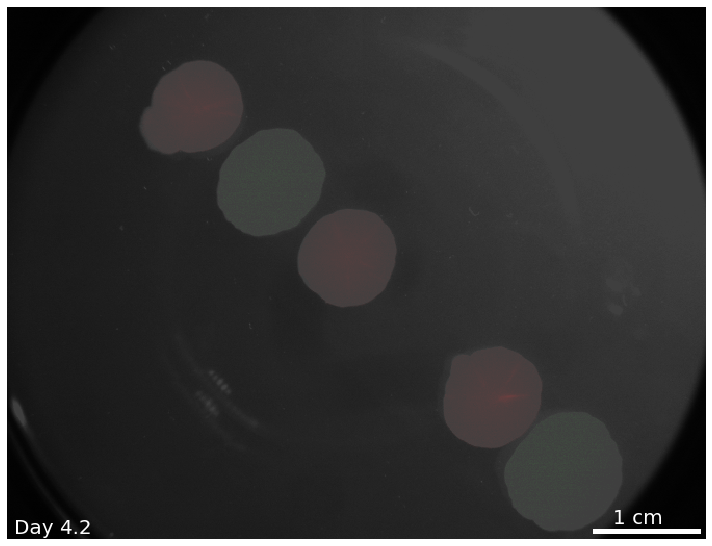

In [83]:
## Make images of control plates

def make_control_img(im_arr, annotation=""):
    plt.close('all')
    
    t_points, h, w, s = im_arr.shape
    frames = t_points
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w, 3])
    fig, axs = plt.subplots(1,1, figsize=(10,8))
    
    # Plot cell densities
    ax = axs
    im = ax.imshow(blank_array, animated=True, vmax=1, vmin=0, interpolation='none')
    #cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(w-90, h-15, "1 cm", fontsize=20, color="white")
    t = ax.text(0.01,0.01, "", fontsize=20, color="white", transform=ax.transAxes)
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w,3))

    frame_i = 0
    labels = uncrop(label_image(im_arr[frame_i,:,:,2])[0])
    rfp_mask = (labels == 1) + (labels == 3) + (labels == 4)
    gfp_mask = (labels == 2) + (labels == 5)
    cells = (im_arr[frame_i,:,:,2] - 200)/200
    cells[cells < 0] = 0
    cells[cells > 1] = 1
    rfp = (im_arr[frame_i,:,:,0] - np.mean(im_arr[frame_i,:50,-50:,0]))/200
    rfp[rfp < 0] = 0
    rfp[rfp > 1] = 1
    gfp = (im_arr[frame_i,:,:,1] - np.mean(im_arr[frame_i,:50,-50:,0]))/100
    gfp[gfp < 0] = 0
    gfp[gfp > 1] = 1
    for j in range(3):
        frame_arr[:,:,j] = cells / 4
    frame_arr[:,:,0] += 3*rfp_mask*rfp/4
    frame_arr[:,:,1] += 3*gfp_mask*gfp/4
    frame_arr[-10:-5, -109:-5, :] = 1
    im.set_array(frame_arr)
    t.set_text(annotation)
    return fig

control_types = ['a3u', 'c3ic', 'a3ic2', 'c3u', 'a3ir', 'c3ir']
control_types = ['c3ic', 'c3u', 'c3ir']
for cntrl in control_types:
    img_dirs = np.sort([x for x in os.listdir() if os.path.isdir(x) if cntrl in x])
    f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs 
               for fn in os.listdir(img_dir) 
               if '.tif' in fn[-4:] if 'convert' not in fn]
    for fn in f_names:
        ct = (get_time_vector_from_fn(fn)['"Brightfield"'][0] - epoch_zero) / (24*3600)
        ann = "Day {:.1f}".format(ct)
        with Image.open(fn) as img:
            channels = ['"RFP"', '"YFP"', '"Brightfield"']
            img_dict, time_dict = get_movie_from_img(img)
            img_len = min([len(time_dict[x]) for x in channels])
            im_arr = np.concatenate([img_dict[channel][:img_len,:,:,:] for channel in channels], axis=3)
        img = skimage.transform.downscale_local_mean(im_arr, (1, 2,2, 1)).astype(np.uint16)
        fig = make_control_img(img, ann)
        fig.savefig("{}.png".format(os.path.dirname(fn)), dpi=400)

In [56]:
# im_arr = skimage.io.imread('../180206_day0_6pm_a3i/MMStack_Pos0.ome.tif')
# im_arr = skimage.io.imread('../180206_day0_9pm_a3i/MMStack_Pos0.ome.tif')
df_replace.columns

Index(['col_size', 'colony', 'gfp', 'gfp_bg', 'rfp', 'rfp_bg', 'time'], dtype='object')

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


6


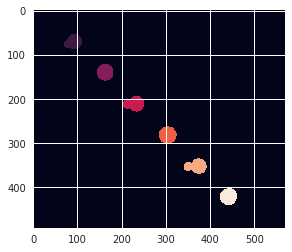

In [55]:
labld, num = label_image(im_arr[-1,:,:,2])
plt.imshow(labld)
print(num)

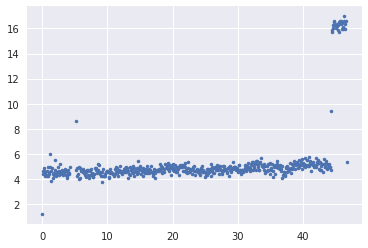

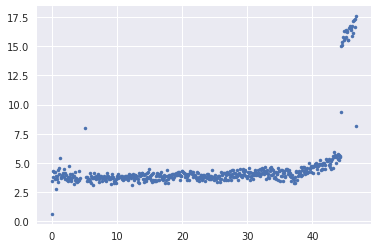

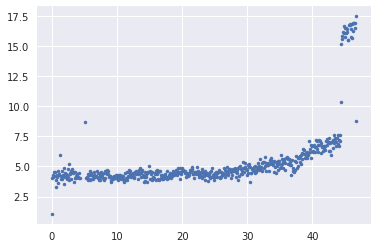

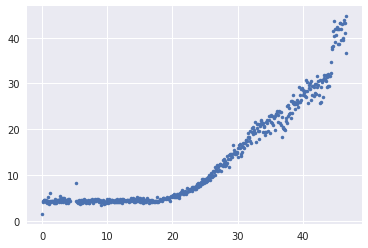

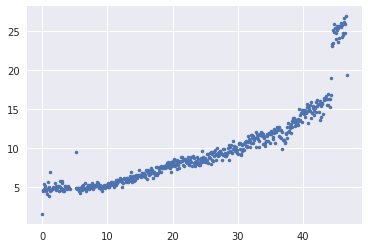

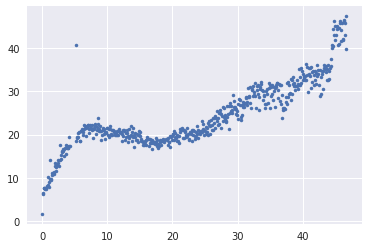

In [4]:
gb = df_replace.groupby("colony")
for i in range(6):
    plt.figure()
    plt.plot((gb.get_group(i).time)/(3600), gb.get_group(i).gfp - gb.get_group(i).gfp_bg,'.')